In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

print('Python Version')
print(sys.version)

print('Sci-Kit Learn Version')
print(sklearn.__version__)

print('Tensorflow version')
print(tf.__version__)
print('Is built with CUDA:',tf.test.is_built_with_cuda())
print('GPU:',tf.config.list_physical_devices('GPU'))

from logicalEELS.models import createDualVAE

2024-10-22 12:03:37.845718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 12:03:40.486566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:/usr/local/cuda/lib64:
2024-10-22 12:03:40.490862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:/usr/local/cuda/lib64:
2024-10-22 12:03:40.490913: W 

Python Version
3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0]
Sci-Kit Learn Version
0.24.2
Tensorflow version
2.11.0
Is built with CUDA: True
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-22 12:03:44.119284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 12:03:44.236628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 12:03:44.237849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
DATA_DIR = './data'
MODEL_DIR = './models'

with np.load(os.path.join(DATA_DIR, 'MXene_EELS_Data.npz')) as data:
    data_X = data['x']
    data_Y = data['y']

energy_axis = np.load(os.path.join(DATA_DIR, 'MXene_EELS_axis.npy'))
dft_counts = np.load(os.path.join(DATA_DIR, 'MXene_DFT_Data.npy'))
dft_labels = np.load(os.path.join(DATA_DIR, 'MXene_DFT_Labels.npy'))

# dvae = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'dualvae_2024-04-30'))
params={
    'INPUT_SHAPE'   :   (240, 1),
    'BATCH_SIZE'    :   32,
    'LATENT_SIZE'   :   16,
    'KERNEL_SIZES'  :   [7, 7, 3, 3],
    'FILTER_SIZES'  :   [16, 32, 32, 64],
    'ALPHA'         :   0.3,
    'DROPOUT'       :   0.2,
    'LR'            :   0.0005,
    'RECON_WEIGHT'  :   1.0,
    'KL_WEIGHT'     :   1.0,
    'CNVRG_WEIGHT'  :   1.0,
}
dvae = createDualVAE(params)
dvae.predict(np.zeros((32,240,1)))
dvae.load_weights(os.path.join(MODEL_DIR, 'dualvae_2024-10-21.weights.h5'))

c_map = [mpl.colormaps['viridis'](255), mpl.colormaps['viridis'](127),mpl.colormaps['viridis'](63), mpl.colormaps['viridis'](0)]

2024-10-22 12:03:45.195418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 12:03:45.201560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 12:03:45.202312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 12:03:45.203070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

1/1 [==============================] - 14s 14s/step


In [3]:
latent_X = dvae.X_encode(data_X)
latent_Y, _ = dvae.Y_encode(data_X)
recon_X = dvae.denoise(data_X)
recon_Y = dvae.predict(data_Y)

428/428 [==============================] - 5s 11ms/step


In [4]:
def plotSpectra(ax, energy, spectra, title=None):
    
    for i in range(24):
        ax.plot(energy, spectra[i*570+300:(i+1)*570+400].mean(axis=(0)))
        # ax.plot(energy, spectra[i].mean(axis=(0)))
    ax.set_xlabel('Energy Loss (eV)')
    ax.set_ylabel('Average Counts')
    if title!=None:
        ax.set_title(title)
    return ax

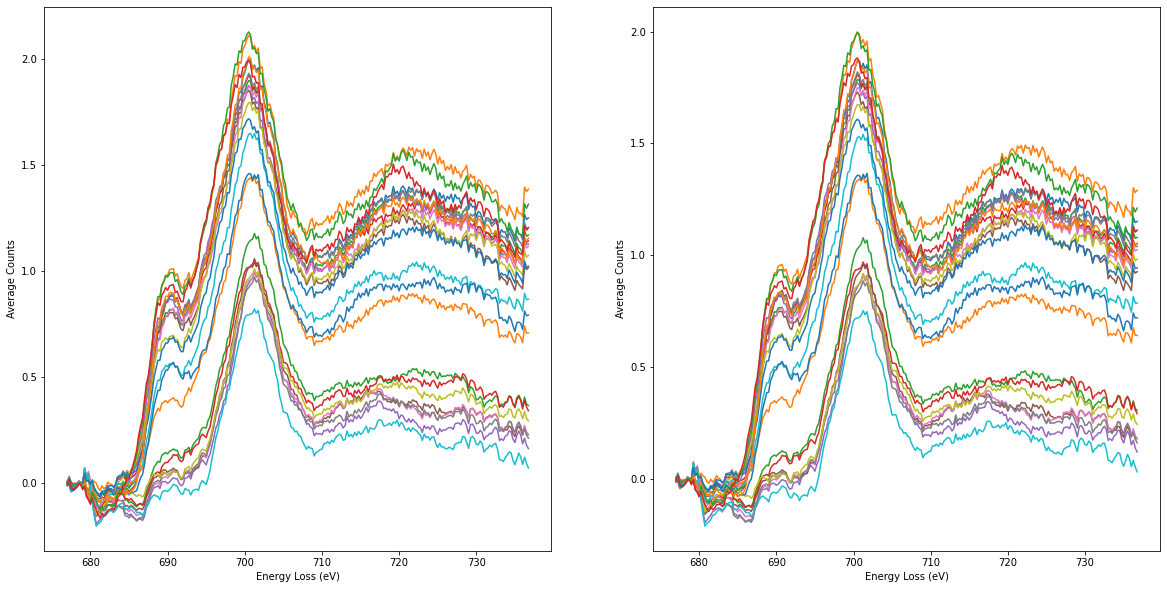

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
plotSpectra(axes[0], energy_axis, recon_X)
plotSpectra(axes[1], energy_axis, recon_Y)
plt.show()

38/38 [==============================] - 0s 6ms/step


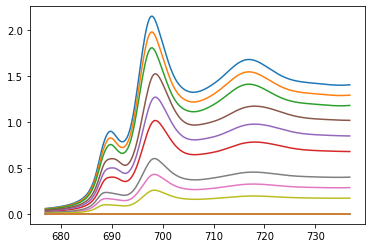

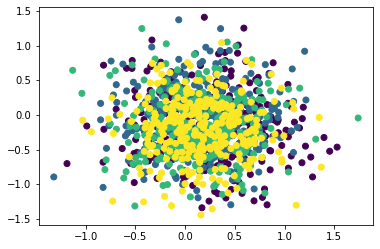

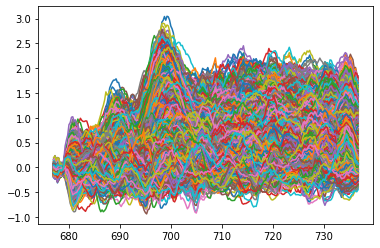

In [6]:
gt_x = dft_counts
gt_label_old = dft_labels

latent_dim = latent_X.shape[1]
n=100
gt_z_mean, gt_z_var = dvae.Y_encoder.predict(gt_x)
gt_z = np.zeros((gt_x.shape[0]*n, latent_dim))
gt_label = np.zeros((gt_x.shape[0]*n), dtype=int)
for i in range(gt_x.shape[0]):
    gt_z[i*n:(i*n)+n] = np.random.normal(gt_z_mean[i], np.exp(0.5 * gt_z_var[i]), (n, latent_dim))
    gt_label[i*n:(i*n)+n] = gt_label_old[i]

gt_pred = dvae.decoder.predict(gt_z)

for i in range(gt_x.shape[0]):
    plt.plot(energy_axis,gt_x[i])
plt.show()

plt.scatter(gt_z[:,0], gt_z[:,1], c=gt_label[:])
plt.show()

for i in range(gt_pred.shape[0]):
    plt.plot(energy_axis,gt_pred[i])
plt.show()

(13680, 16)


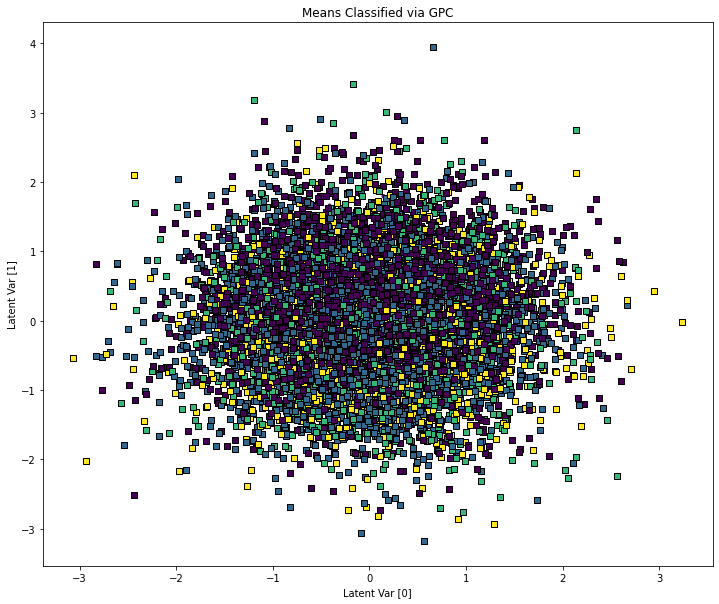

In [7]:
print(latent_Y.shape)
gpc = GaussianProcessClassifier().fit(gt_z, gt_label)

gpc_class_aec = np.zeros_like((data_Y.shape[0], gt_label[-1]))
gpc_class_aec = gpc.predict(latent_Y)

plt.figure(figsize=(12,10))
# print(gmm_means.shape, gmm_class.shape)
plt.scatter(gt_z[:,0], gt_z[:,9], c=gt_label, marker='.')
plt.scatter(latent_Y[:,0], latent_Y[:,9], c=gpc_class_aec, marker='s', edgecolors='k')
plt.xlabel("Latent Var [0]")
plt.ylabel("Latent Var [1]")
plt.title('Means Classified via GPC')
plt.show()

In [8]:
def plot_SI_class(color, xlabels=None, ylabels=None):
    '''
    
    '''
    # colors = [mpl.colormaps['viridis'](255), mpl.colormaps['viridis'](127),mpl.colormaps['viridis'](63), mpl.colormaps['viridis'](0)]
    def get_img_loc(imgNum):
        img_loc = np.zeros(2, dtype=int)
        img_loc[0] = imgNum % 3
        img_loc[1] = imgNum // 3
        if img_loc[1]>=7:
            img_loc[1] -= 8
        img_loc[1] += 1
        return img_loc
    SI_color = color.reshape(-1,30,19)
    fig, axes = plt.subplots(nrows=3, ncols=8, dpi=300)
    for i in range(SI_color.shape[0]):
        xx,yy = get_img_loc(i)
        axes[xx,yy].imshow(SI_color[i], vmin=0, vmax=3, cmap=mpl.colormaps['viridis'].reversed())
        axes[xx,yy].xaxis.set_ticklabels([])
        axes[xx,yy].xaxis.set_ticks([])
        axes[xx,yy].yaxis.set_ticks([])
        # axes[xx,yy].axis('off')
    if xlabels!=None:
        for i,xlabel in enumerate(xlabels):
            axes[-1,i].set_xlabel(xlabel)
    if ylabels!=None:
        for i,ylabel in enumerate(ylabels):
            axes[i,0].set_ylabel(ylabel)
    return fig, axes

def plot_SI_color(color, xlabels=None, ylabels=None):
    '''
    
    '''
    def get_img_loc(imgNum):
        img_loc = np.zeros(2, dtype=int)
        img_loc[0] = imgNum % 3
        img_loc[1] = imgNum // 3
        if img_loc[1]>=7:
            img_loc[1] -= 8
        img_loc[1] += 1
        return img_loc
    SI_color = color.reshape(-1,30,19,4)
    fig, axes = plt.subplots(nrows=3, ncols=8, dpi=300)
    for i in range(SI_color.shape[0]):
        xx,yy = get_img_loc(i)
        axes[xx,yy].imshow(SI_color[i])
        axes[xx,yy].xaxis.set_ticklabels([])
        axes[xx,yy].xaxis.set_ticks([])
        axes[xx,yy].yaxis.set_ticks([])
        # axes[xx,yy].axis('off')
    if xlabels!=None:
        for i,xlabel in enumerate(xlabels):
            axes[-1,i].set_xlabel(xlabel)
    if ylabels!=None:
        for i,ylabel in enumerate(ylabels):
            axes[i,0].set_ylabel(ylabel)
    return fig, axes

T = ['Initial', '200 C', '300 C', '400 C', '500 C', '600 C', '700 C', '800 C']    
AList = ['Area 1', 'Area 3', 'Area 4']

Semi-supervised Classification of Latent Spectra


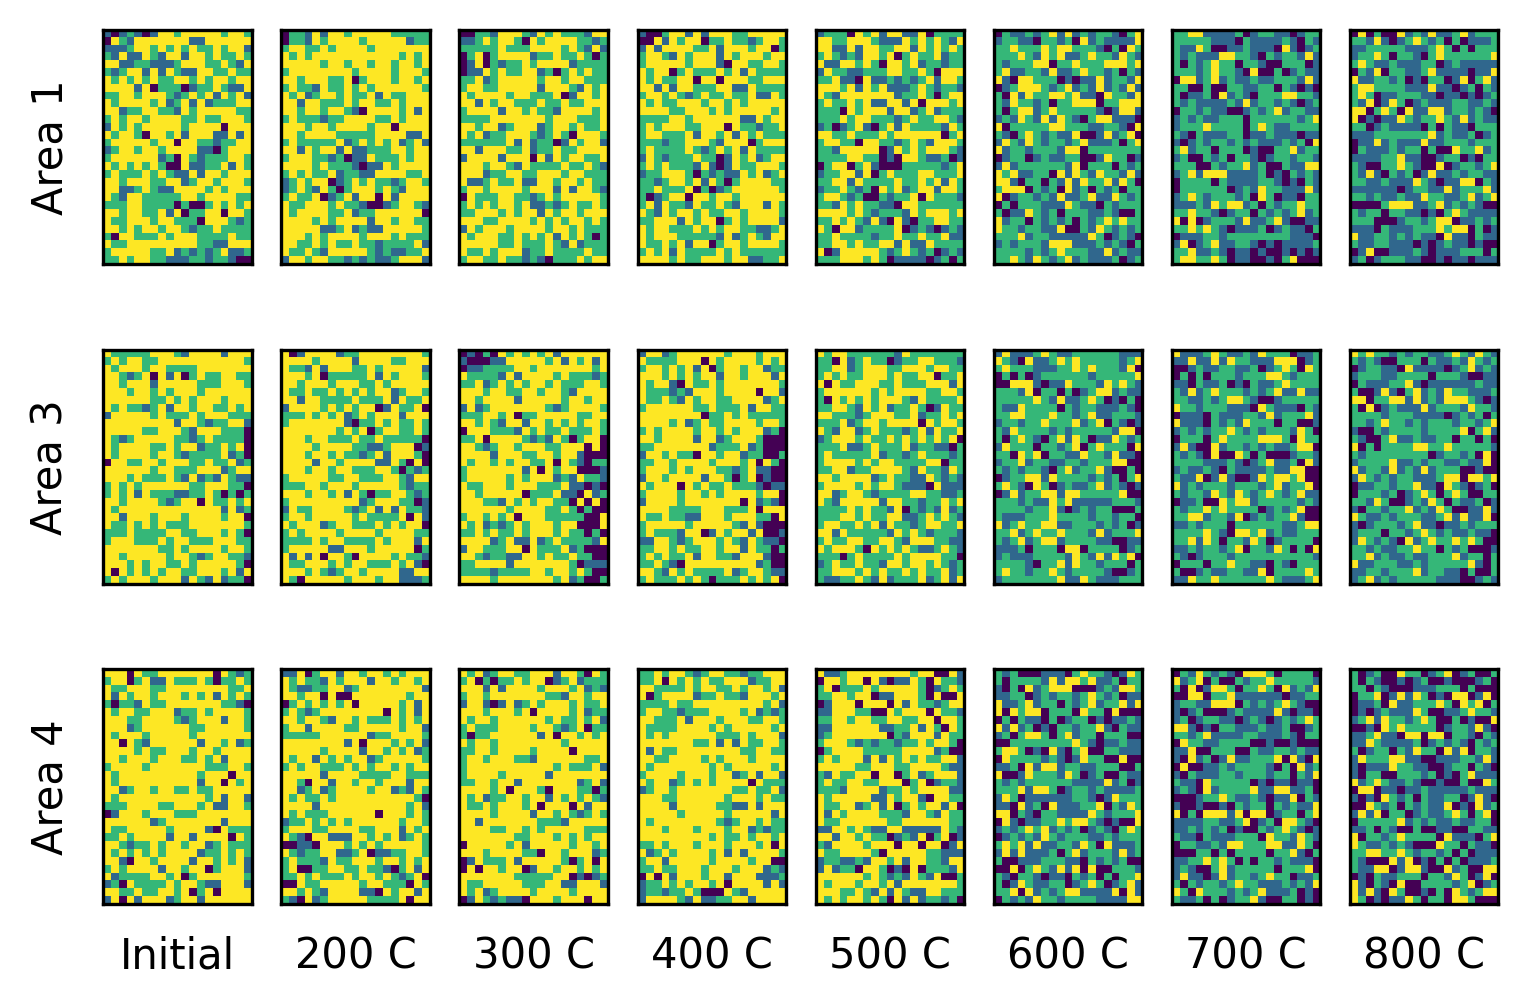

In [9]:
# gmm = GaussianMixture(n_components=200, random_state=42).fit(latent_X)

# mixtures = gmm.predict(latent_X)
# gmm_means = gmm.means_

# plt.figure(figsize=(12,10))
# plt.scatter(tsne_embed[:, 0], tsne_embed[:,1], c=mixtures)
# plt.xlabel("tSNE[0]")
# plt.ylabel("tSNE[1]")
# plt.title('tSNE Unsupervised GMM Clusting')
# plt.show()

knn = KNeighborsClassifier(n_neighbors=10).fit(gt_z, gt_label)
# knn = KNeighborsClassifier(n_neighbors=1).fit(latent_embed, mse_class_pca)
# gmm_class = knn.predict(gmm_means[:,5:7])
# knn_class_aec = gmm_class[mixtures,:].astype(float)
knn_class_aec = knn.predict(latent_X)

# plt.figure(figsize=(12,10))
# # print(gmm_means.shape, gmm_class.shape)
# plt.scatter(gt_z[:,5], gt_z[:,7], c=gt_label, marker='.')
# plt.scatter(gmm_means[:,5], gmm_means[:,7], c=gmm_class, marker='s', edgecolors='k')
# plt.xlabel("latent[0]")
# plt.ylabel("latent[1]")
# plt.title('Means Classified via KNN')
# plt.show()


# plt.figure(figsize=(12,10))
# # print(gmm_means.shape, gmm_class.shape)
# plt.scatter(tsne_embed[:,0], tsne_embed[:,1], c=knn_class_aec)
# plt.xlabel("tSNE[0]")
# plt.ylabel("tSNE[1]")
# plt.title('tSNE Semi-supervised Classifier')
# plt.show()



plot_SI_class(knn_class_aec, xlabels=T, ylabels=AList)
print('Semi-supervised Classification of Latent Spectra')
plt.show()

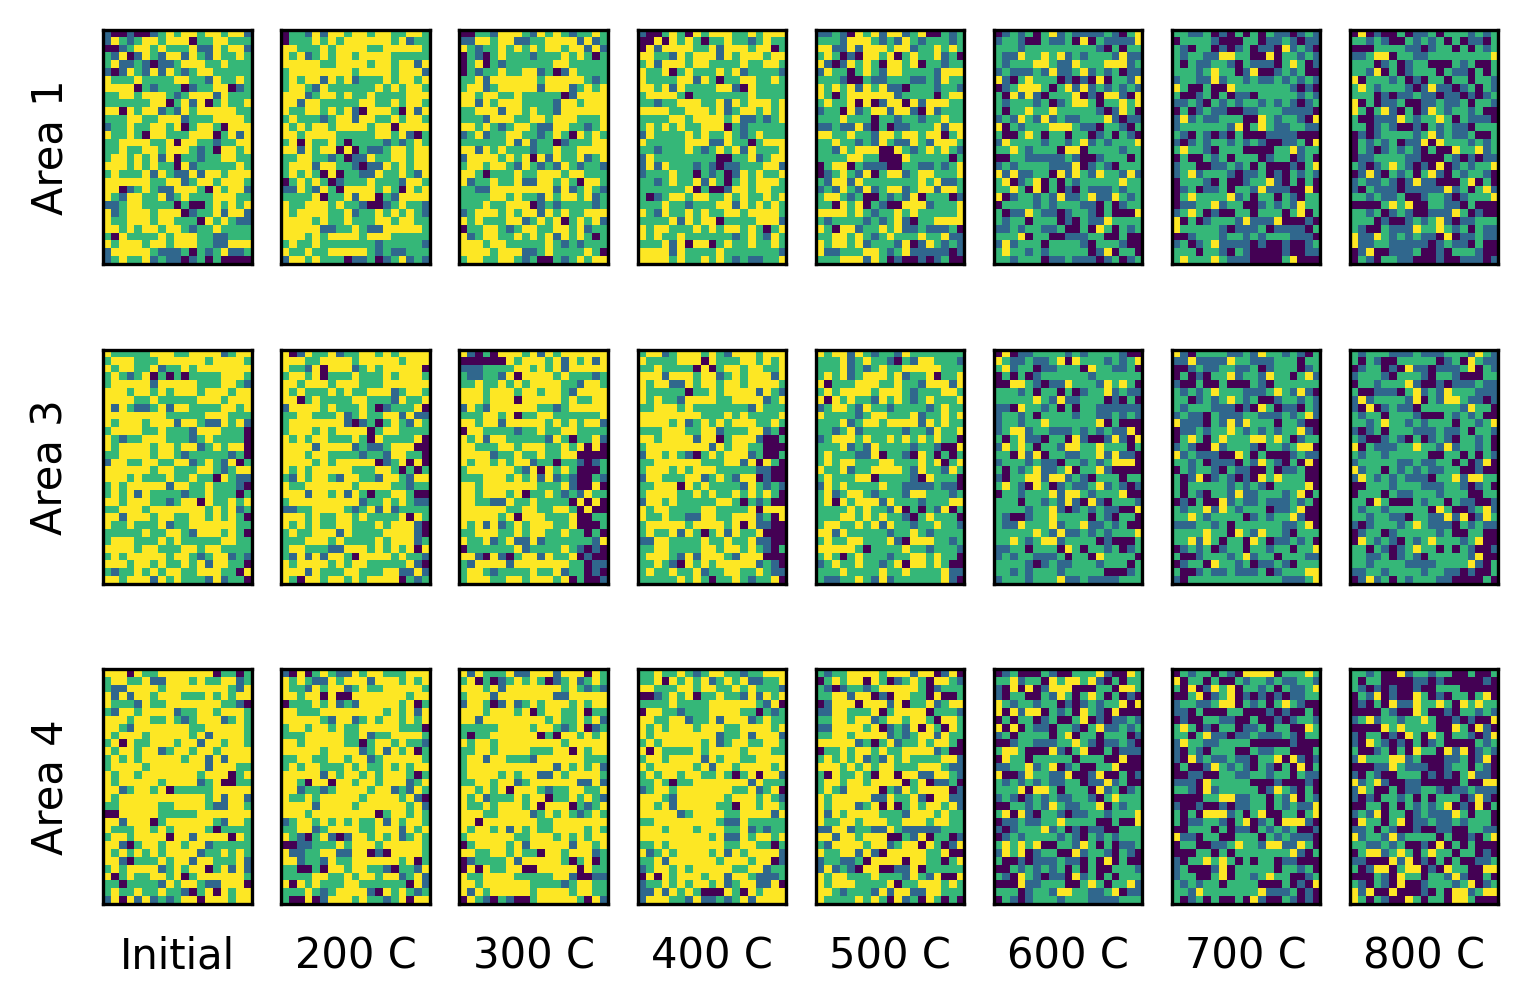

In [10]:
plot_SI_class(gpc_class_aec, xlabels=T, ylabels=AList)
plt.show()